# Diffusion: First-order Kinetics, Multi-Component, Unsteady

In this tutorial, we will explore the 1D unsteady diffusion equation:

$$\frac{\partial c}{\partial t} + \mathrm{div}(- D \, \mathrm{grad}(c)) = r(c)$$

The terms in the equation represent:
- **Accumulation**: $\frac{\partial c}{\partial t}$
- **Diffusion**: $\mathrm{div}(- D \, \mathrm{grad}(c))$
- **Reaction**: $r(c)$

Using Euler-backward time discretization with all terms evaluated implicitly in `PyMRM`, the discretized form becomes:
```python
(c - c_old) / dt - div_mat @ (D * grad_mat @ c) = r(c)
```

For this tutorial, we consider first-order kinetics, where $r(c) = -k \, c$.

## Stationary Diffusion with First-order Kinetics

The stationary diffusion equation with first-order kinetics for a single component is given by:

$$k\, c - D \, \mathrm{div} (\mathrm{grad}(c)) = 0$$

Here:
- $k$ is the reaction coefficient.
- $D$ is the diffusion coefficient.
- $c$ is the concentration field.

### Discretization
We discretize the equation as:
```python
k * c - div_mat @ (D * (grad_mat @ c + grad_bc)) = 0
```

Rearranging terms, we obtain a matrix-vector equation:
```python
(k * identity_matrix - div_mat @ (D * grad_mat)) @ c = div_mat @ (D * grad_bc)
```

#### Explanation
- The **identity matrix** appears because the term $k\, c$ is factored out. It can be created using the `eye_array` function from `scipy.sparse` or the `construct_coefficient_matrix` function from `PyMRM`.
- The **right-hand side (rhs)** matrix is constructed using the boundary conditions.
- The resulting matrix-vector equation can be solved using `spsolve` from `scipy.sparse.linalg`.

#### Implementation
The `construct_coefficient_matrix` function in `PyMRM` is used to place field values on the diagonal of a matrix. If the values are uniform across all components of `c`, a single value and the shape of the field can be provided. The value will be broadcasted to all diagonal elements.

Once the matrix on the rhs is constructed, the system of equations can be solved numerically.

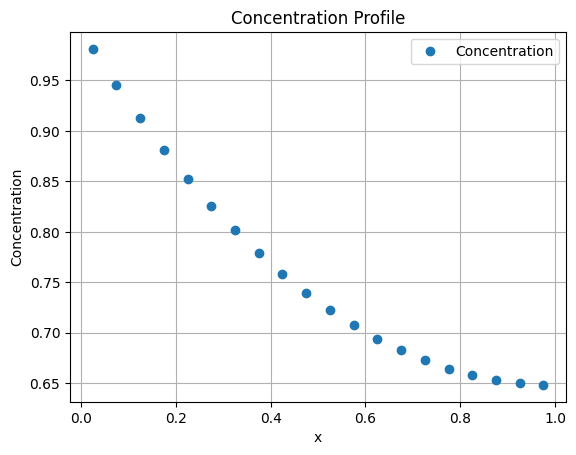

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_div, construct_coefficient_matrix
import scipy.sparse.linalg as spla

num_x = 20 # Number of grid points in x direction	
L = 1.0 # Length of the domain in x direction
D = 1.0 # Diffusion coefficient
k = 1.0 # Reaction coefficient
c_b = 1.0 # Boundary condition at x=0
x_f = np.linspace(0, 1, num_x + 1) # x grid points
x_c = 0.5*(x_f[1:] + x_f[:-1]) # x cell centers

bc = ({'a':0, 'b':1,'d':c_b}, # Dirichlet boundary condition
      {'a':1, 'b':0,'d':0}) # Neumann boundary condition

# Construct the coefficient matrix
k_mat = construct_coefficient_matrix(k, shape=(num_x,))

# Construct the gradient and divergence matrices
grad_mat, grad_bc = construct_grad((num_x,), x_f, x_c, bc)
div_mat = construct_div((num_x,), x_f)

A_mat = k_mat - div_mat @ (D*grad_mat)
rhs_vec = div_mat @ (D*grad_bc)

# Solve the system of equations
c = spla.spsolve(A_mat, rhs_vec)

# Plot the results
plt.plot(x_c, c, 'o', label='Concentration')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Concentration Profile')
plt.legend()
plt.grid()
plt.show()


### Exercises

1. **Experiment with Parameters**:
   - Vary the number of grid points (`num_x`) and observe how it affects the solution.
   - Modify the physical parameters such as the diffusion coefficient ($D$) and reaction coefficient ($k$).
   - Hint: The dimensionless group $\phi = L \sqrt{k/D}$, known as the Thiele modulus, determines the shape of the concentration profile.

2. **Derive an Analytical Solution**:
   - Derive an analytical expression for the concentration profile.
   - Hint: Consider the Neumann boundary condition on the right-hand side. The solution takes the form $\cosh(\alpha (L-x))$.
   - Substitute this form into the equation to determine $\alpha$. Use the Dirichlet boundary condition to find the missing multiplication factor.

3. **Compare Analytical and Numerical Solutions**:
   - Compare the analytical solution with the numerical one.
   - Pay special attention to cases with a small number of grid cells and large values of $\phi$.

4. **Explore Boundary Conditions**:
   - Modify the boundary conditions and observe their impact on the solution.
   - For example, try using different Dirichlet or Neumann conditions at the boundaries.

## Cylindrical and Spherical Geometries

In cylindrical and spherical coordinates, the diffusion term takes the following forms:

$$\frac{1}{r}\frac{\partial}{\partial r} \left (r\, \frac{\partial c}{\partial r} \right), \text{ and } \frac{1}{r^2}\frac{\partial}{\partial r} \left (r^2\, \frac{\partial c}{\partial r} \right)$$

The general form of the diffusion term in these geometries can be expressed as:

$$\frac{1}{r^\nu}\frac{\partial}{\partial r} \left (r^\nu \, \frac{\partial c}{\partial r} \right),$$

where $\nu = 0$: Cartesian coordinates, $\nu = 1$: Cylindrical coordinates and $\nu = 2$: Spherical coordinates. This $\nu$ dependence arises from the geometry of the system and can be derived using Gauss's theorem applied to an infinitesimally thin cylindrical ring or spherical shell, where $r^\nu$ accounts for the surface area. 
In the `PyMRM` function `construct_div` a `nu` parameter with value 0, 1 or 2 can be provided.

## Stationary First Order Reaction in a Spherical Particle 

This is code for the stationary diffusion-reaction inside a spherical particle:

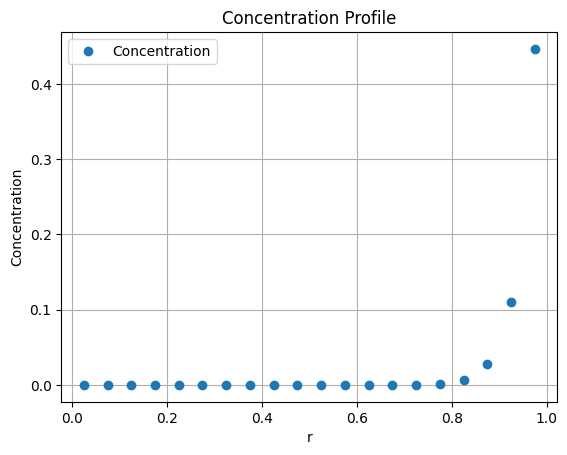

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_div, construct_coefficient_matrix, non_uniform_grid
import scipy.sparse.linalg as spla

num_r = 20 # Number of grid points in x direction	
R = 1.0 # Length of the domain in x direction
D = 1.0 # Diffusion coefficient
k = 1000.0 # Reaction coefficient
c_b = 1.0 # Boundary condition at x=0
r_f = np.linspace(0, 1, num_r + 1) # r grid points
#dr_large = 0.1*R
#r_f = non_uniform_grid(0, R, num_r+1, dr_large, 0.75)

r_c = 0.5*(r_f[1:] + r_f[:-1]) # x cell centers

bc = ({'a':1, 'b':0,'d':0}, # Neumann boundary condition
      {'a':0, 'b':1,'d':c_b}) # Dirichlet boundary condition

# Construct the coefficient matrix
k_mat = construct_coefficient_matrix(k, shape=(num_r,))

# Construct the gradient and divergence matrices
grad_mat, grad_bc = construct_grad((num_r,), r_f, r_c, bc)
div_mat = construct_div((num_r,), r_f, nu=2)

A_mat = k_mat - div_mat @ (D*grad_mat)
rhs_vec = div_mat @ (D*grad_bc)

# Solve the system of equations
c = spla.spsolve(A_mat, rhs_vec)

# Plot the results
plt.plot(r_c, c, 'o', label='Concentration')
plt.xlabel('r')
plt.ylabel('Concentration')
plt.title('Concentration Profile')
plt.legend()
plt.grid()
plt.show()

### Exercise

The analytical expression for the concentration profile inside the spherical particle is given by:

$$ c(r) = c_b \, \frac{R \, \sinh \left( \sqrt{\frac{k}{D}} \, r \right) }{r \, \sinh \left( \sqrt{\frac{k}{D}} \, R \right)}$$

#### Tasks:
1. Compare the numerical solution to the analytical solution by varying the physical and numerical parameters.
2. For high reaction rate constants ($k$), observe how the concentration gradients near the boundary become steep. In such cases, higher resolution near the boundary is required.
3. Use the `non_uniform_grid` function to achieve local grid refinement near the boundary. Uncomment the call to `non_uniform_grid` in the code and analyze whether the profile near the wall is better represented at high reaction rates.

## Multicomponent Stationary Diffusion-Reaction

The `PyMRM` package supports modeling multi-component systems using multi-dimensional arrays. For a system with three components (`num_c = 3`), the concentration of each species can be represented as an array with dimensions `c.shape = (num_r, num_c)`, where `num_r` is the number of spatial grid points.

When solving the discretized equations as a matrix-vector system, the multi-dimensional array is accessed in a linear fashion. By default, `NumPy` uses C-style row-major ordering, meaning the last axis (species index) varies the fastest in memory. This ensures that for each spatial cell, the species concentrations are stored sequentially in memory. The `numpy.ravel_multi_index` and `numpy.unravel_index` functions can be used to convert between multi-dimensional and linear indices.

Consider a reaction in series:

$$A \rightarrow B \rightarrow C,$$

with reaction rate constants $k_1$ and $k_2$. Without spatial dependence, the kinetics can be expressed as:

$$\frac{d}{dt} \begin{bmatrix} c_A \\ c_B \\ c_C \end{bmatrix} = \begin{bmatrix} -k_1 & 0 & 0 \\ k_1 & -k_2 & 0 \\ 0 & k_2 & 0 \end{bmatrix} \begin{bmatrix} c_A \\ c_B \\ c_C \end{bmatrix}.$$

The diffusion coefficients for each species can vary and are typically stored in a diagonal matrix. The `PyMRM` function `construct_coefficient_matrix` is used to create this diagonal matrix, ensuring that the diffusion coefficients.
Fluxes are computed from gradients that are defined on cell-face (also called staggered) positions. The `axis` parameter in `construct_coefficient_matrix` specifies the axis along which the staggered positions are computed.

The code below solves the stationary diffusion-reaction problem for three reacting species inside a spherical particle.

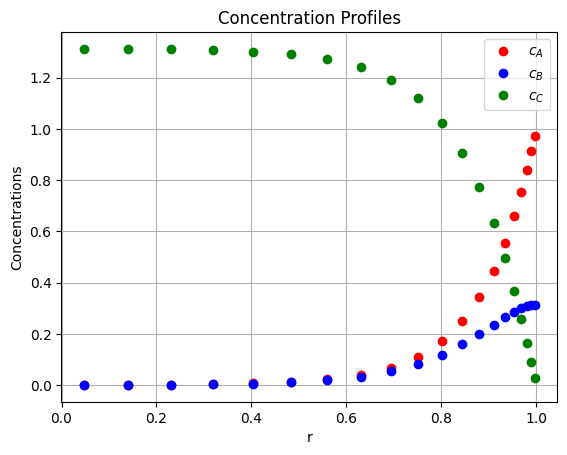

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_div, construct_coefficient_matrix, non_uniform_grid
import scipy.sparse.linalg as spla
from scipy.sparse import coo_array, block_diag

num_c = 3  # Number of components
num_r = 20  # Number of grid points in the radial direction
R = 1.0  # Radius of the spherical particle
D_A = 1.0  # Diffusion coefficient for species A
D_B = 1.0  # Diffusion coefficient for species B
D_C = 1.0  # Diffusion coefficient for species C
k_1 = 100.0  # Reaction rate constant for A -> B
k_2 = 200.0  # Reaction rate constant for B -> C
c_b = 1.0  # Boundary condition for species A at the particle surface

# Generate a non-uniform grid for the radial positions
dr_large = 0.1 * R  # Larger spacing near the center
r_f = non_uniform_grid(0, R, num_r + 1, dr_large, 0.75)  # Radial face positions
r_c = 0.5 * (r_f[1:] + r_f[:-1])  # Radial cell center positions

# Define boundary conditions for the system
bc = (
    {'a': 1, 'b': 0, 'd': 0},  # Neumann boundary condition at r=0
    {'a': [[0, 1, 0]], 'b': [[1, 0, 1]], 'd': [[c_b, 0, 0]]}  # Boundary conditions at r=R, Dirichlet for A and C, Neumann for B.
)

# Create the reaction rate coefficient matrix as a block diagonal matrix
block = coo_array([[k_1, 0, 0], [-k_1, k_2, 0], [0, -k_2, 0]])  # Reaction rates
k_mat = block_diag([block] * num_r, format='csc')  # Block diagonal matrix

# Create the diffusion coefficient matrix for all species
D_mat = construct_coefficient_matrix([[D_A, D_B, D_C]], shape=(num_r, num_c), axis=0)

# Construct the gradient and divergence matrices
grad_mat, grad_bc = construct_grad((num_r, num_c), r_f, r_c, bc, axis=0)  # Gradient matrix
div_mat = construct_div((num_r, num_c), r_f, nu=2, axis=0)  # Divergence matrix

# Assemble the system matrix and right-hand side vector
A_mat = k_mat - div_mat @ (D_mat @ grad_mat)  # System matrix
rhs_vec = div_mat @ (D_mat @ grad_bc)  # Right-hand side vector

# Solve the system of equations
c = spla.spsolve(A_mat, rhs_vec).reshape((-1, 3))  # Reshape solution to (num_r, num_c)

# Plot the concentration profiles for all species
plt.plot(r_c, c[:, 0], 'or', label=r'$c_A$')
plt.plot(r_c, c[:, 1], 'ob', label=r'$c_B$')
plt.plot(r_c, c[:, 2], 'og', label=r'$c_C$')
plt.xlabel('r')
plt.ylabel('Concentrations')
plt.title('Concentration Profiles')
plt.legend()
plt.grid()
plt.show()

### Exercise

- Change the boundary conditions for each species and observe their impact on the concentration profiles. For example, impose a Neumann boundary condition for species $A$ at the particle surface or a Dirichlet condition for species $B$.
- Modify the diffusion coefficients ($D_A$, $D_B$, $D_C$) for each species and observe how the concentration profiles change.
- Include reverse reactions for the system, e.g., $B \rightarrow A$ and $C \rightarrow B$, with appropriate rate constants.
- Modify the reaction network from sequential reactions to parallel reactions, e.g., $A \rightarrow B$ and $A \rightarrow C$.


## Unsteady Diffusion

For unsteady diffusion, we include the accumulation term in the governing equations and solve them using a backward Euler time-stepping scheme. The governing equation is:

```python
(c - c_old) / dt - div_mat @ (D_mat @ (grad_mat @ c + grad_bc)) = r(c)
```

For first-order reactions, where `r(c) = -k_mat @ c`, this becomes:

```python
accum_mat @ (c - c_old) - div_mat @ (D_mat @ (grad_mat @ c + grad_bc)) = - k_mat @ c
(accum_mat + k_mat - div_mat @ D_mat @ grad_mat) @ c = (div_mat @ D_mat @ grad_bc) + accum_mat @ c_old
```

Here:
- `accum_mat` represents the accumulation term, i.e., a diagonal matrix with `1/dt` on its main diagonal.
- `k_mat` is the reaction rate matrix.
- `div_mat` and `grad_mat` are the divergence and gradient matrices, respectively.
- `D_mat` is the diagonal matrix with diffusion coefficients on its diagonal.
- `grad_bc` accounts for boundary conditions.

The solution is computed iteratively over time steps. First, run the previous cells to define the required matrices, then execute the following code to solve the unsteady problem.

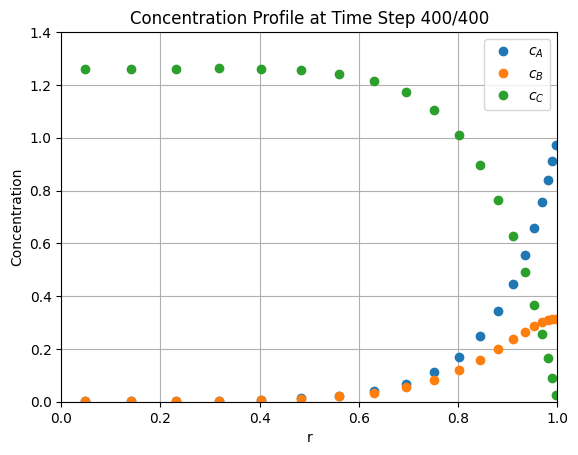

In [4]:
import time
from IPython.display import clear_output, display

# Initialize the concentration array with zeros
c = np.zeros((num_r, num_c))

# Time-stepping parameters
dt = 1e-3  # Time step size
num_time_steps = 400  # Total number of time steps

# Construct the accumulation matrix for the time-dependent term
accum_matrix = construct_coefficient_matrix(1.0/dt, shape=(num_r, num_c))

# Assemble the system matrix (A_mat) and constant part of the RHS vector
A_mat = accum_matrix + k_mat - div_mat @ (D_mat @ grad_mat)
rhs_vec_const = div_mat @ (D_mat @ grad_bc)

# Set up the figure and axis for live plotting
fig, ax = plt.subplots()
label = [r'$c_A$', r'$c_B$', r'$c_C$']
lines = [ax.plot(r_c, c[:, i], 'o', label=label[i])[0] for i in range(num_c)]
ax.set_xlim(0, R)
ax.set_ylim(0, 1.4 * c_b)
ax.set_xlabel('r')
ax.set_ylabel('Concentration')
ax.set_title('Concentration Profiles Over Time')
ax.legend()
ax.grid()
plt.show()

# Time-stepping loop
for step in range(num_time_steps):
    # Update the RHS vector with the current concentration values
    rhs_vec = rhs_vec_const + accum_matrix @ c.reshape((-1, 1))

    # Solve the linear system to compute the new concentration values
    c[...] = spla.spsolve(A_mat, rhs_vec).reshape((-1, num_c))

    # Update the plot with the new concentration profiles
    for i, line in enumerate(lines):
        line.set_ydata(c[:, i])
    ax.set_title(f'Concentration Profile at Time Step {step + 1}/{num_time_steps}')

    # Clear the previous output and display the updated plot
    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)  # Pause to allow the plot to update
    